In [104]:
import boto3
import time 
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

from collections import namedtuple
from urllib.parse import urlparse
transcribe = boto3.client('transcribe')
s3 =  boto3.client('s3')

In [19]:
media=[
    's3://broadcast-monitoring-assets/audio/BarackObamaPodcast1.mp3',
    's3://broadcast-monitoring-assets/audio/VOA_U.S._News_in_Russian_90sec.mp3',
    's3://broadcast-monitoring-assets/audio/hongkong-covid-with-audio-scenarios-90sec.mp3'
]
output_bucket='video-processing-angelaw-496010403454-us-east-1'

In [34]:
def genereate_job_name(prefix='lang_id'):
    timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
    job_id = prefix + timestamp
    return job_id

def start_job(media_s3_uri, job_prefix='lang_id'):
    job_id = genereate_job_name(prefix=job_prefix)
    response = transcribe.start_transcription_job(
        TranscriptionJobName=job_id,
        IdentifyLanguage = True,
        MediaFormat='mp3',
        Media={
            'MediaFileUri': media_s3_uri
        },
        OutputBucketName=output_bucket
    )
    return job_id


In [86]:
TranscribeJobRecord = namedtuple ('TranscribeJobRecord', ['JobCompletion','JobStart','LangaugeDetectionTime','LangaugeDetectionScore','LangaugeDetected','LanguageId','JobResponse'])


In [89]:
def timed_transcribe(media_s3_uri):
    completed = False
    language_detected = None
    
    starttime=time.time()
    
    job_prefix = os.path.splitext(os.path.basename(media_s3_uri))[0]
    
    job_id = start_job(media_s3_uri, job_prefix)
    print('start job {} took {:10.4f} seconds'.format(job_id, time.time() - starttime))
    while not completed:
        response = transcribe.get_transcription_job(
            TranscriptionJobName=job_id
        )
        status = response['TranscriptionJob']['TranscriptionJobStatus']
        if status in [ 'COMPLETED' , 'FAILED' ]:
            completed = True
        if not language_detected and 'LanguageCode' in response['TranscriptionJob']:
            language_detected = response['TranscriptionJob']['LanguageCode']
            language_score = response['TranscriptionJob']['IdentifiedLanguageScore']
            language_detection_seconds = time.time() - starttime
            print('{} detected in {:10.3f} seconds with {} score'.format(language_detected, language_detection_seconds, language_score))
        time.sleep(0.5)
    if status != 'COMPLETED':
        print(f'job {job_id} failed for {media_s3_uri}')
        return TranscribeJobRecord(JobCompletion=None, 
                               JobStart=None, 
                               LangaugeDetectionTime=None, 
                               LangaugeDetectionScore=None, 
                               LangaugeDetected=None, 
                               LanguageId=None, 
                               JobResponse =response)
    
    job_startTime = response['TranscriptionJob']['StartTime']
    job_creationTime = response['TranscriptionJob']['CreationTime']
    job_completionTime = response['TranscriptionJob']['CompletionTime']
    job_start_seconds = (job_startTime-job_creationTime).total_seconds()
    job_completion_seconds = (job_completionTime-job_creationTime).total_seconds()
    print('job started in {:10.3f} seconds'.format(job_start_seconds))
    print('job completed in {:10.3f} seconds'.format(job_completion_seconds))
    u = urlparse(response['TranscriptionJob']['Transcript']['TranscriptFileUri'])
    bucket = u.path.split('/')[1]
    path = '/'.join(u.path.split('/')[2:])
    transcript_file = os.path.join('tmp', f'{job_id}.json')
    s3.download_file(bucket, path, transcript_file)
    with open(transcript_file, 'r') as f:
        output = json.load(f)
        print('transcript: ' + output['results']['transcripts'][0]['transcript'][:150] + '...')
        language_id_alts = output['results']['language_identification']
        print('language_id: ' + json.dumps(language_id_alts))

    return TranscribeJobRecord(JobCompletion=job_completion_seconds, 
                               JobStart=job_start_seconds, 
                               LangaugeDetectionTime=language_detection_seconds, 
                               LangaugeDetectionScore=language_score, 
                               LangaugeDetected=language_detected, 
                               LanguageId=language_id_alts, 
                               JobResponse = response)


In [90]:
response = timed_transcribe('s3://broadcast-monitoring-assets/audio/mandarin-6sec/covid_mandarin000.mp3')

start job covid_mandarin000-2020-06-02-17-56-56 took     0.3926 seconds
zh-CN detected in     32.360 seconds with 1.0 score
job started in      0.030 seconds
job completed in     58.250 seconds
transcript: 截至一月二十三日，香港共出现两例新型冠状病毒感染的肺炎个案，其中手...
language_id: [{"score": "1", "code": "zh-CN"}, {"score": "0.0001", "code": "es-US"}, {"score": "0.0001", "code": "id-ID"}, {"score": "0.0001", "code": "ms-MY"}, {"score": "0.0001", "code": "es-ES"}]


In [92]:
def get_audio_s3_uris(s3_bucket, s3_prefix):
    s3_paths = []
    s3bucket = boto3.resource('s3').Bucket(s3_bucket)

    for i, s3_object in enumerate(s3bucket.objects.filter(Prefix=s3_prefix)):
        if s3_object.key.endswith('mp3'):
            s3_paths.append(f's3://{s3_bucket}/{s3_object.key}')
    return s3_paths

In [93]:
s3_paths = get_audio_s3_uris('broadcast-monitoring-assets','audio/')

In [94]:
records = []
for s3_uri in s3_paths:
    records.append(timed_transcribe(s3_uri))

start job BarackObamaPodcast1-2020-06-02-17-59-03 took     0.3116 seconds
en-US detected in     47.140 seconds with 0.5891635417938232 score
job started in      0.024 seconds
job completed in    164.576 seconds
transcript: This is Senator Barack Obama, and today is Thursday, September 8th, 2005. Welcome to my first podcast. You know, in the future we're gonna be discussi...
language_id: [{"score": "0.5892", "code": "en-US"}, {"score": "0.2527", "code": "en-AU"}, {"score": "0.1537", "code": "en-GB"}, {"score": "0.0036", "code": "en-AB"}, {"score": "0.0004", "code": "en-IE"}]
start job VOA_U.S._News_in_Russian_90sec-2020-06-02-18-01-49 took     0.1820 seconds
ru-RU detected in     54.064 seconds with 0.9999224543571472 score
job started in      0.022 seconds
job completed in    207.216 seconds
transcript: власти США подтвердили, чтобы газ добывают предприятия, захваченного террористами. Приземлился американский военный самолет, который должен вывести ос...
language_id: [{"score": "0.9999

In [97]:
records[0]

TranscribeJobRecord(JobCompletion=164.576, JobStart=0.024, LangaugeDetectionTime=47.14001202583313, LangaugeDetectionScore=0.5891635417938232, LangaugeDetected='en-US', LanguageId=[{'score': '0.5892', 'code': 'en-US'}, {'score': '0.2527', 'code': 'en-AU'}, {'score': '0.1537', 'code': 'en-GB'}, {'score': '0.0036', 'code': 'en-AB'}, {'score': '0.0004', 'code': 'en-IE'}], JobResponse={'TranscriptionJob': {'TranscriptionJobName': 'BarackObamaPodcast1-2020-06-02-17-59-03', 'TranscriptionJobStatus': 'COMPLETED', 'LanguageCode': 'en-US', 'MediaSampleRateHertz': 44100, 'MediaFormat': 'mp3', 'Media': {'MediaFileUri': 's3://broadcast-monitoring-assets/audio/BarackObamaPodcast1.mp3'}, 'Transcript': {'TranscriptFileUri': 'https://s3.amazonaws.com/video-processing-angelaw-496010403454-us-east-1/BarackObamaPodcast1-2020-06-02-17-59-03.json'}, 'StartTime': datetime.datetime(2020, 6, 2, 13, 59, 4, 67000, tzinfo=tzlocal()), 'CreationTime': datetime.datetime(2020, 6, 2, 13, 59, 4, 43000, tzinfo=tzlocal(

In [96]:
respons

58.25

In [99]:
filtered_records = records[4:]

In [109]:
lang_detection_time = np.array([r.LangaugeDetectionTime for r in filtered_records if r.LangaugeDetectionTime is not None])

In [110]:
len(lang_detection_time)

22

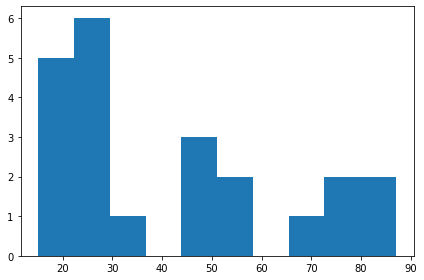

In [111]:
fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist(lang_detection_time)


In [114]:
np.median(lang_detection_time)

31.30412745475769

In [115]:
lang_detection_time

array([45.0291729 , 28.58757186, 26.01508212, 25.91366768, 15.595222  ,
       15.16394925, 26.04337311, 24.18059015, 26.4344418 , 17.44418979,
       16.63693595, 18.67512417, 34.02068305, 56.42417693, 76.64306378,
       81.30487394, 87.01156592, 75.85345602, 69.09301972, 57.38299012,
       49.19913197, 50.34604192])

In [116]:
completion_time = np.array([r.JobCompletion for r in filtered_records if r.JobCompletion is not None])

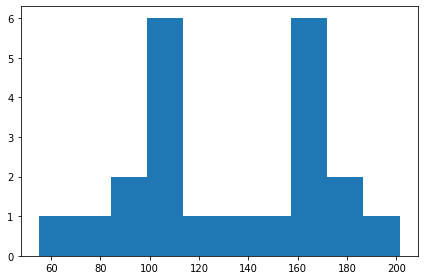

In [117]:
fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist(completion_time)


In [118]:
completion_time

array([159.779,  99.665, 100.838, 120.037, 101.562,  87.591,  70.803,
        88.914,  54.911, 112.074, 110.46 , 106.681, 132.235, 164.75 ,
       171.654, 181.032, 201.321, 177.092, 161.303, 165.891, 158.415,
       156.141])

In [119]:
from scipy import stats

In [120]:
stats.describe(completion_time)

DescribeResult(nobs=22, minmax=(54.911, 201.321), mean=131.05222727272727, variance=1620.582215422078, skewness=-0.09564323820390873, kurtosis=-1.1040085470633172)

In [121]:
np.median(completion_time)

126.13600000000001